In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms

In [2]:
from torchvision.models import resnet18, ResNet18_Weights

In [6]:
import torch.nn as nn

In [17]:
from utils.early_stopping import EarlyStopping

In [24]:
import numpy as np
import os

In [28]:
import matplotlib.pyplot as plt

Picking up a pretrained resnet model:

In [36]:
model = resnet18(weights = ResNet18_Weights.DEFAULT) 

In [38]:
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [39]:
list(model.children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Creating a new model where - truncate the last fc layer and add a single node for detecting ants/bees. binary classification

In [8]:
z = nn.Linear(2,1)

In [10]:
z.weight

Parameter containing:
tensor([[0.6704, 0.3268]], requires_grad=True)

In [80]:
class BinClassifierResnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
        self.classifier = nn.Linear(512,1)
        nn.init.xavier_normal_(self.classifier.weight)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(batch_size,-1)
        x = self.classifier(x)
        return self.sigmoid(x)

In [81]:
classification_model = BinClassifierResnet()

Freeze the weights of the resnet model

In [82]:
for param in classification_model.feature_extractor.parameters():
    param.requires_grad = False

In [83]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classification_model.parameters()), lr=1e-3)

In [84]:
criterion = nn.BCELoss()

In [85]:
# the learning rate scheduler:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Implementing the Early Stopping callback:

In [86]:
early_stopper = EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    checkpoint_path='resnet_cp.pt',
    restore_best_weights=True
)


Load the data:

In [87]:
# the original resnet model performs the following transformations on the data:
# - images are initially resized to 256 - followed by a central crop of size 224, values are then rescaled to 0.0 to 1.0, 
# - then normalized using the mean and std values below
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [88]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [89]:
# import the data
data_dir = '../../data/hymenoptera_data'
sets = ['train','val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True,num_workers=0) for x in ['train','val']}

In [90]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [91]:
image_datasets['train'][0]

(tensor([[[-0.6794, -0.6623, -0.6965,  ..., -0.6281, -0.6452, -0.6281],
          [-0.6794, -0.6623, -0.6965,  ..., -0.6281, -0.6452, -0.6623],
          [-0.6794, -0.6623, -0.6965,  ..., -0.6452, -0.6452, -0.6794],
          ...,
          [-0.5938, -0.6281, -0.6452,  ..., -0.7137, -0.6965, -0.6965],
          [-0.6109, -0.6281, -0.6109,  ..., -0.6965, -0.6794, -0.6965],
          [-0.6109, -0.6109, -0.6109,  ..., -0.6794, -0.6623, -0.6965]],
 
         [[ 0.6254,  0.6604,  0.6604,  ...,  0.7304,  0.7129,  0.7479],
          [ 0.6254,  0.6604,  0.6604,  ...,  0.7304,  0.7129,  0.7304],
          [ 0.6254,  0.6604,  0.6604,  ...,  0.7129,  0.7129,  0.7129],
          ...,
          [ 0.8004,  0.7829,  0.8004,  ...,  0.6779,  0.6954,  0.6779],
          [ 0.7829,  0.7829,  0.8004,  ...,  0.6604,  0.6604,  0.6429],
          [ 0.7829,  0.7829,  0.7829,  ...,  0.6429,  0.6429,  0.6078]],
 
         [[ 2.2914,  2.3088,  2.2391,  ...,  2.3437,  2.3263,  2.3437],
          [ 2.2914,  2.3088,

Visualise some of the images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


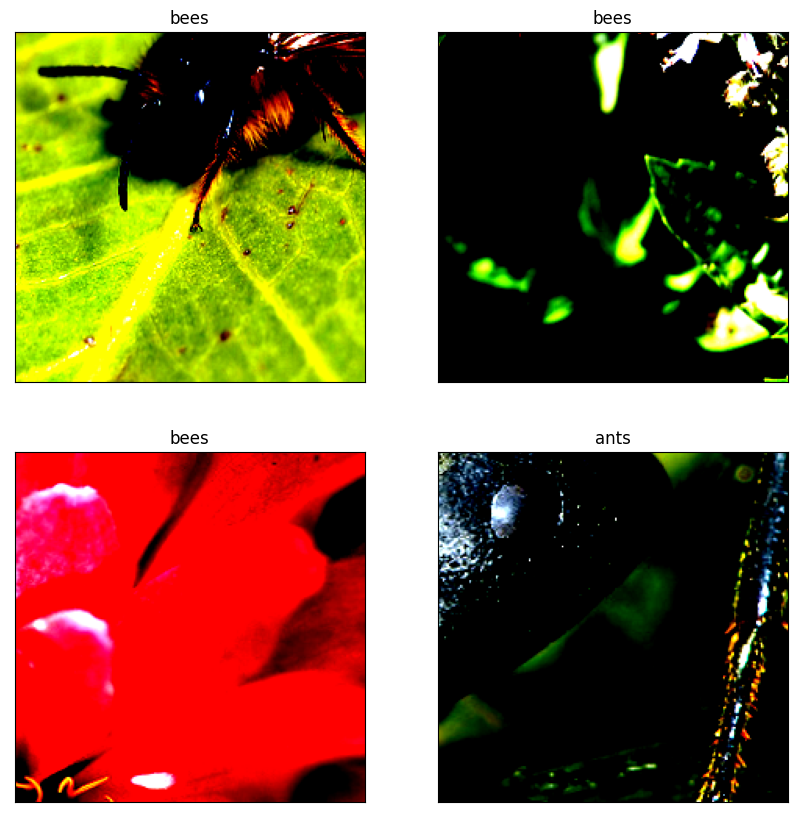

In [92]:
fig, ax = plt.subplots(2,2, figsize=(10,10));
counter = 0
batch = next(iter(dataloaders['train']))
batch_images, batch_labels = batch[0],batch[1] 
for i in range(2):
    for j in range(2):
        image, label = batch_images[counter],batch_labels[counter]
        label = class_names[label]
        image = torch.permute(image, (1,2,0)).clone().numpy()
        ax[i,j].imshow(image);
        ax[i,j].set_title(label);
        ax[i,j].set_xticks([]); ax[i,j].set_yticks([])
        counter+=1

the model training function:

In [ ]:
def train(epochs):
    train_loss = [0] * epochs
    train_acc = [0] * epochs
    val_loss = [0] * epochs
    val_acc = [0] * epochs
    for epoch in range(epochs):
        classification_model.train()
        for x_batch, y_batch in dataloaders['train']:
            # perform the forward pass
            outputs = classification_model(x_batch)[:,0]
            # compute the loss
            loss = criterion(outputs, y_batch.float())
            # compute the gradients
            loss.backward()
            # optimize
            optimizer.step()
            # zero the gradients
            optimizer.zero_grad()

            train_loss[epoch] += loss.item()*y_batch.shape[0]

            # compute the accuracy
            is_correct = ((outputs >= 0.5).float() == y_batch.float()).float().sum()
            train_acc[epoch] += is_correct
        train_loss[epoch] /= len(dataloaders['train'].dataset)
        train_acc[epoch] /= len(dataloaders['train'].dataset)

        # validation:
        classification_model.eval()
        with torch.no_grad():
            for vx_batch, vy_batch in dataloaders['val']:
                val_outputs = classification_model(vx_batch)[:,0]
                vloss = criterion(val_outputs, vy_batch.float())
                val_iscorrect = ((val_outputs >= 0.5).float() == vy_batch.float()).float().sum()

                val_loss[epoch] += vloss.item() * vy_batch.shape[0]
                val_acc[epoch] += val_iscorrect
            val_loss[epoch] /= len(dataloaders['val'].dataset)
            val_acc[epoch] /= len(dataloaders['val'].dataset)

        
        print(f"epoch: {epoch+1} | Train Acc: {train_acc[epoch]} | Train Loss: {train_loss[epoch]} | Val Acc: {val_acc[epoch]} | Val Loss: {val_loss[epoch]}")
        scheduler.step(val_loss[epoch])
        early_stopper(val_loss[epoch], classification_model, optimizer, epoch)

        if early_stopper.should_stop:
            break
    return train_loss,train_acc,val_loss,val_acc


In [ ]:
hist = train(200)

epoch: 1 | Train Acc: 0.5532786846160889 | Train Loss: 0.7232393534457098 | Val Acc: 0.7385621070861816 | Val Loss: 0.5929898661530875
Metric improved to 0.5930. Checkpoint saved at epoch 0
epoch: 2 | Train Acc: 0.6557376980781555 | Train Loss: 0.6055854988879845 | Val Acc: 0.8366013169288635 | Val Loss: 0.39585847334534513
Metric improved to 0.3959. Checkpoint saved at epoch 1
epoch: 3 | Train Acc: 0.7295082211494446 | Train Loss: 0.5304636960146857 | Val Acc: 0.8627451062202454 | Val Loss: 0.34983760946326786
Metric improved to 0.3498. Checkpoint saved at epoch 2
epoch: 4 | Train Acc: 0.7745901346206665 | Train Loss: 0.4997812579156923 | Val Acc: 0.8627451062202454 | Val Loss: 0.3244002127861665
Metric improved to 0.3244. Checkpoint saved at epoch 3
epoch: 5 | Train Acc: 0.7909836173057556 | Train Loss: 0.4426069159488209 | Val Acc: 0.8888888955116272 | Val Loss: 0.2734961875903061
Metric improved to 0.2735. Checkpoint saved at epoch 4
epoch: 6 | Train Acc: 0.8278688788414001 | Train